<a href="https://colab.research.google.com/github/jyesudian/AnoNetworkData/blob/main/Luflow_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: Need help in deriving PCA for a dataset. I need sample code. Also, I would like to use the dataset LuFlow which is available in my Google Drive. I think I need to do data engineering on the dataset. Can you give the step by step example and the code accordingly?
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
### To check whether GPU is used.
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available and being used.")
    print("GPU Details:", gpu_available)
else:
    print("GPU is not available. Using CPU.")

GPU is available and being used.
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from IPython.display import Image
import os, datetime

In [5]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report,roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [6]:
from google.colab import drive
drive.mount('/content/drive')
# Define the file path to your dataset in Google Drive
#file_path = '/content/drive/MyDrive/LuFlow.csv'
#file_path = '/content/drive/MyDrive/VIT/Dataset/LuFlow2021/luflow.csv'


Mounted at /content/drive


In [7]:
file_path_1 = '/content/drive/MyDrive/VIT/Dataset/LuFlow2021/2022.06.12.csv'
file_path_2 = '/content/drive/MyDrive/VIT/Dataset/LuFlow2021/2022.06.13.csv'
file_path_3 = '/content/drive/MyDrive/VIT/Dataset/LuFlow2021/2022.06.14.csv'

In [8]:
# Define the file paths in Google Drive
saved_entropy_file_path = '/content/drive/MyDrive/VIT/Dataset/LuFlow2021/WithEntropies.csv'
saved_noentropy_file_path = '/content/drive/MyDrive/VIT/Dataset/LuFlow2021/WithOutEntropies.csv'

# Read the CSV files back into pandas DataFrames
df_with_entropies_loaded = pd.read_csv(saved_entropy_file_path)
df_without_entropies_loaded = pd.read_csv(saved_noentropy_file_path)

# Optional: Display the first few rows and shape to verify they are loaded correctly
print("First 5 rows of df_with_entropies_loaded:")
print(df_with_entropies_loaded.head())
print("\nShape of df_with_entropies_loaded:")
print(df_with_entropies_loaded.shape)

First 5 rows of df_with_entropies_loaded:
   avg_ipt  bytes_in  bytes_out  dest_ip  dest_port  entropy  num_pkts_out  \
0      0.0         0          0      786    31306.0      0.0             1   
1      0.0         0          0      786    24298.0      0.0             1   
2      0.0         0          0      786    31789.0      0.0             1   
3      0.0         0          0      786    29409.0      0.0             1   
4      0.0         0          0      786    60965.0      0.0             1   

   num_pkts_in  proto  src_ip  src_port  total_entropy    label  duration  \
0            0      6     786   47613.0            0.0  outlier       0.0   
1            0      6     786   47613.0            0.0  outlier       0.0   
2            0      6     786   47613.0            0.0  outlier       0.0   
3            0      6     786   47613.0            0.0  outlier       0.0   
4            0      6     786   47613.0            0.0  outlier       0.0   

                time_start

**Now Proceed With Entropies as the Entropy calculation is done by the Luflow dataset providers itself.**

In [9]:
def dropInfNull(df):
    print (df.shape)

    # replace infinity value as null value
    df = df.replace(["Infinity", "infinity"], np.inf)
    df = df.replace([np.inf, -np.inf], np.nan)

    # drop all null values
    df.dropna(inplace=True)

    print (df.shape)

    return df

In [10]:
%%time
network_data_d1 = dropInfNull(df_with_entropies_loaded)

(1068376, 19)
(964168, 19)
CPU times: user 1.52 s, sys: 48.5 ms, total: 1.56 s
Wall time: 1.56 s


In [11]:
#Get the unique labels
unique_labels = network_data_d1['label'].unique()

#Get the counts of each unique label
label_counts = network_data_d1['label'].value_counts()

#Print the results

print("Unique Labels:")
print(unique_labels)

print("\nCounts of Each Label:")
print(label_counts)

Unique Labels:
['outlier' 'benign' 'malicious']

Counts of Each Label:
label
benign       517209
outlier      368843
malicious     78116
Name: count, dtype: int64


In an anomaly detection context, "outlier" often signifies something unusual or potentially suspicious, even if it doesn't fit a known malicious signature. Grouping "malicious" and "outlier" together allows your model to learn to distinguish between "normal" traffic and any form of unusual or potentially harmful traffic captured in these two categories.

In [12]:
network_data_d1['binary_label'] = network_data_d1['label'].apply(lambda x: 0 if x == 'benign' else 1)

## After converting the binary_label, we can drop the label column from the dataset
del_columns = ['label']

network_data_d1 = network_data_d1.drop(columns=del_columns, errors='ignore')

In [13]:
#Get the counts of each unique label
label_counts = network_data_d1['binary_label'].value_counts()
print("\nCounts of Each Label:")
print(label_counts)


Counts of Each Label:
binary_label
0    517209
1    446959
Name: count, dtype: int64


In [14]:
df_balanced = network_data_d1

**Understanding the Data Type of the Dataset**

In [15]:
# Access the dtypes attribute
feature_data_types = df_balanced.dtypes

# Print the data types
print("Data Types of Features:")
print(feature_data_types)

Data Types of Features:
avg_ipt                 float64
bytes_in                  int64
bytes_out                 int64
dest_ip                   int64
dest_port               float64
entropy                 float64
num_pkts_out              int64
num_pkts_in               int64
proto                     int64
src_ip                    int64
src_port                float64
total_entropy           float64
duration                float64
time_start_dt            object
time_end_dt              object
start_hour_of_day         int64
start_day_of_week         int64
start_minute_of_hour      int64
binary_label              int64
dtype: object


**Raw datetime64[ns] objects cannot be directly used as input features for most standard ML/ANN algorithms. These algorithms expect numerical inputs. As the temporal values such as start_hour_of_day, start_day_of_week and start_minute_of_hour is captured with in dataset, those date time format columns can be removed.**

In [16]:
df_balanced = df_balanced.drop(columns=['time_start_dt', 'time_end_dt'])

**Drop Constant Column**

In [17]:
%%time
# drop the constant columns (which varience is 0)
variances = df_balanced.var(numeric_only=True)
constant_columns = variances[variances == 0].index
df_balanced = df_balanced.drop(constant_columns, axis=1)

print(constant_columns)
print (df_balanced.shape)

Index(['dest_ip', 'src_ip'], dtype='object')
(964168, 15)
CPU times: user 72 ms, sys: 19.3 ms, total: 91.3 ms
Wall time: 90.2 ms


**Drop Duplicate Column**

In [18]:
duplicates = set()
for i in range(0, len(df_balanced.columns)):
    col1 = df_balanced.columns[i]
    for j in range(i+1, len(df_balanced.columns)):
        col2 = df_balanced.columns[j]
        if(df_balanced[col1].equals(df_balanced[col2])):
            duplicates.add(col2)

print (duplicates)
df_balanced.drop(duplicates, axis=1, inplace=True)
print (df_balanced.shape)

set()
(964168, 15)


**Drop Columns based on correlation**

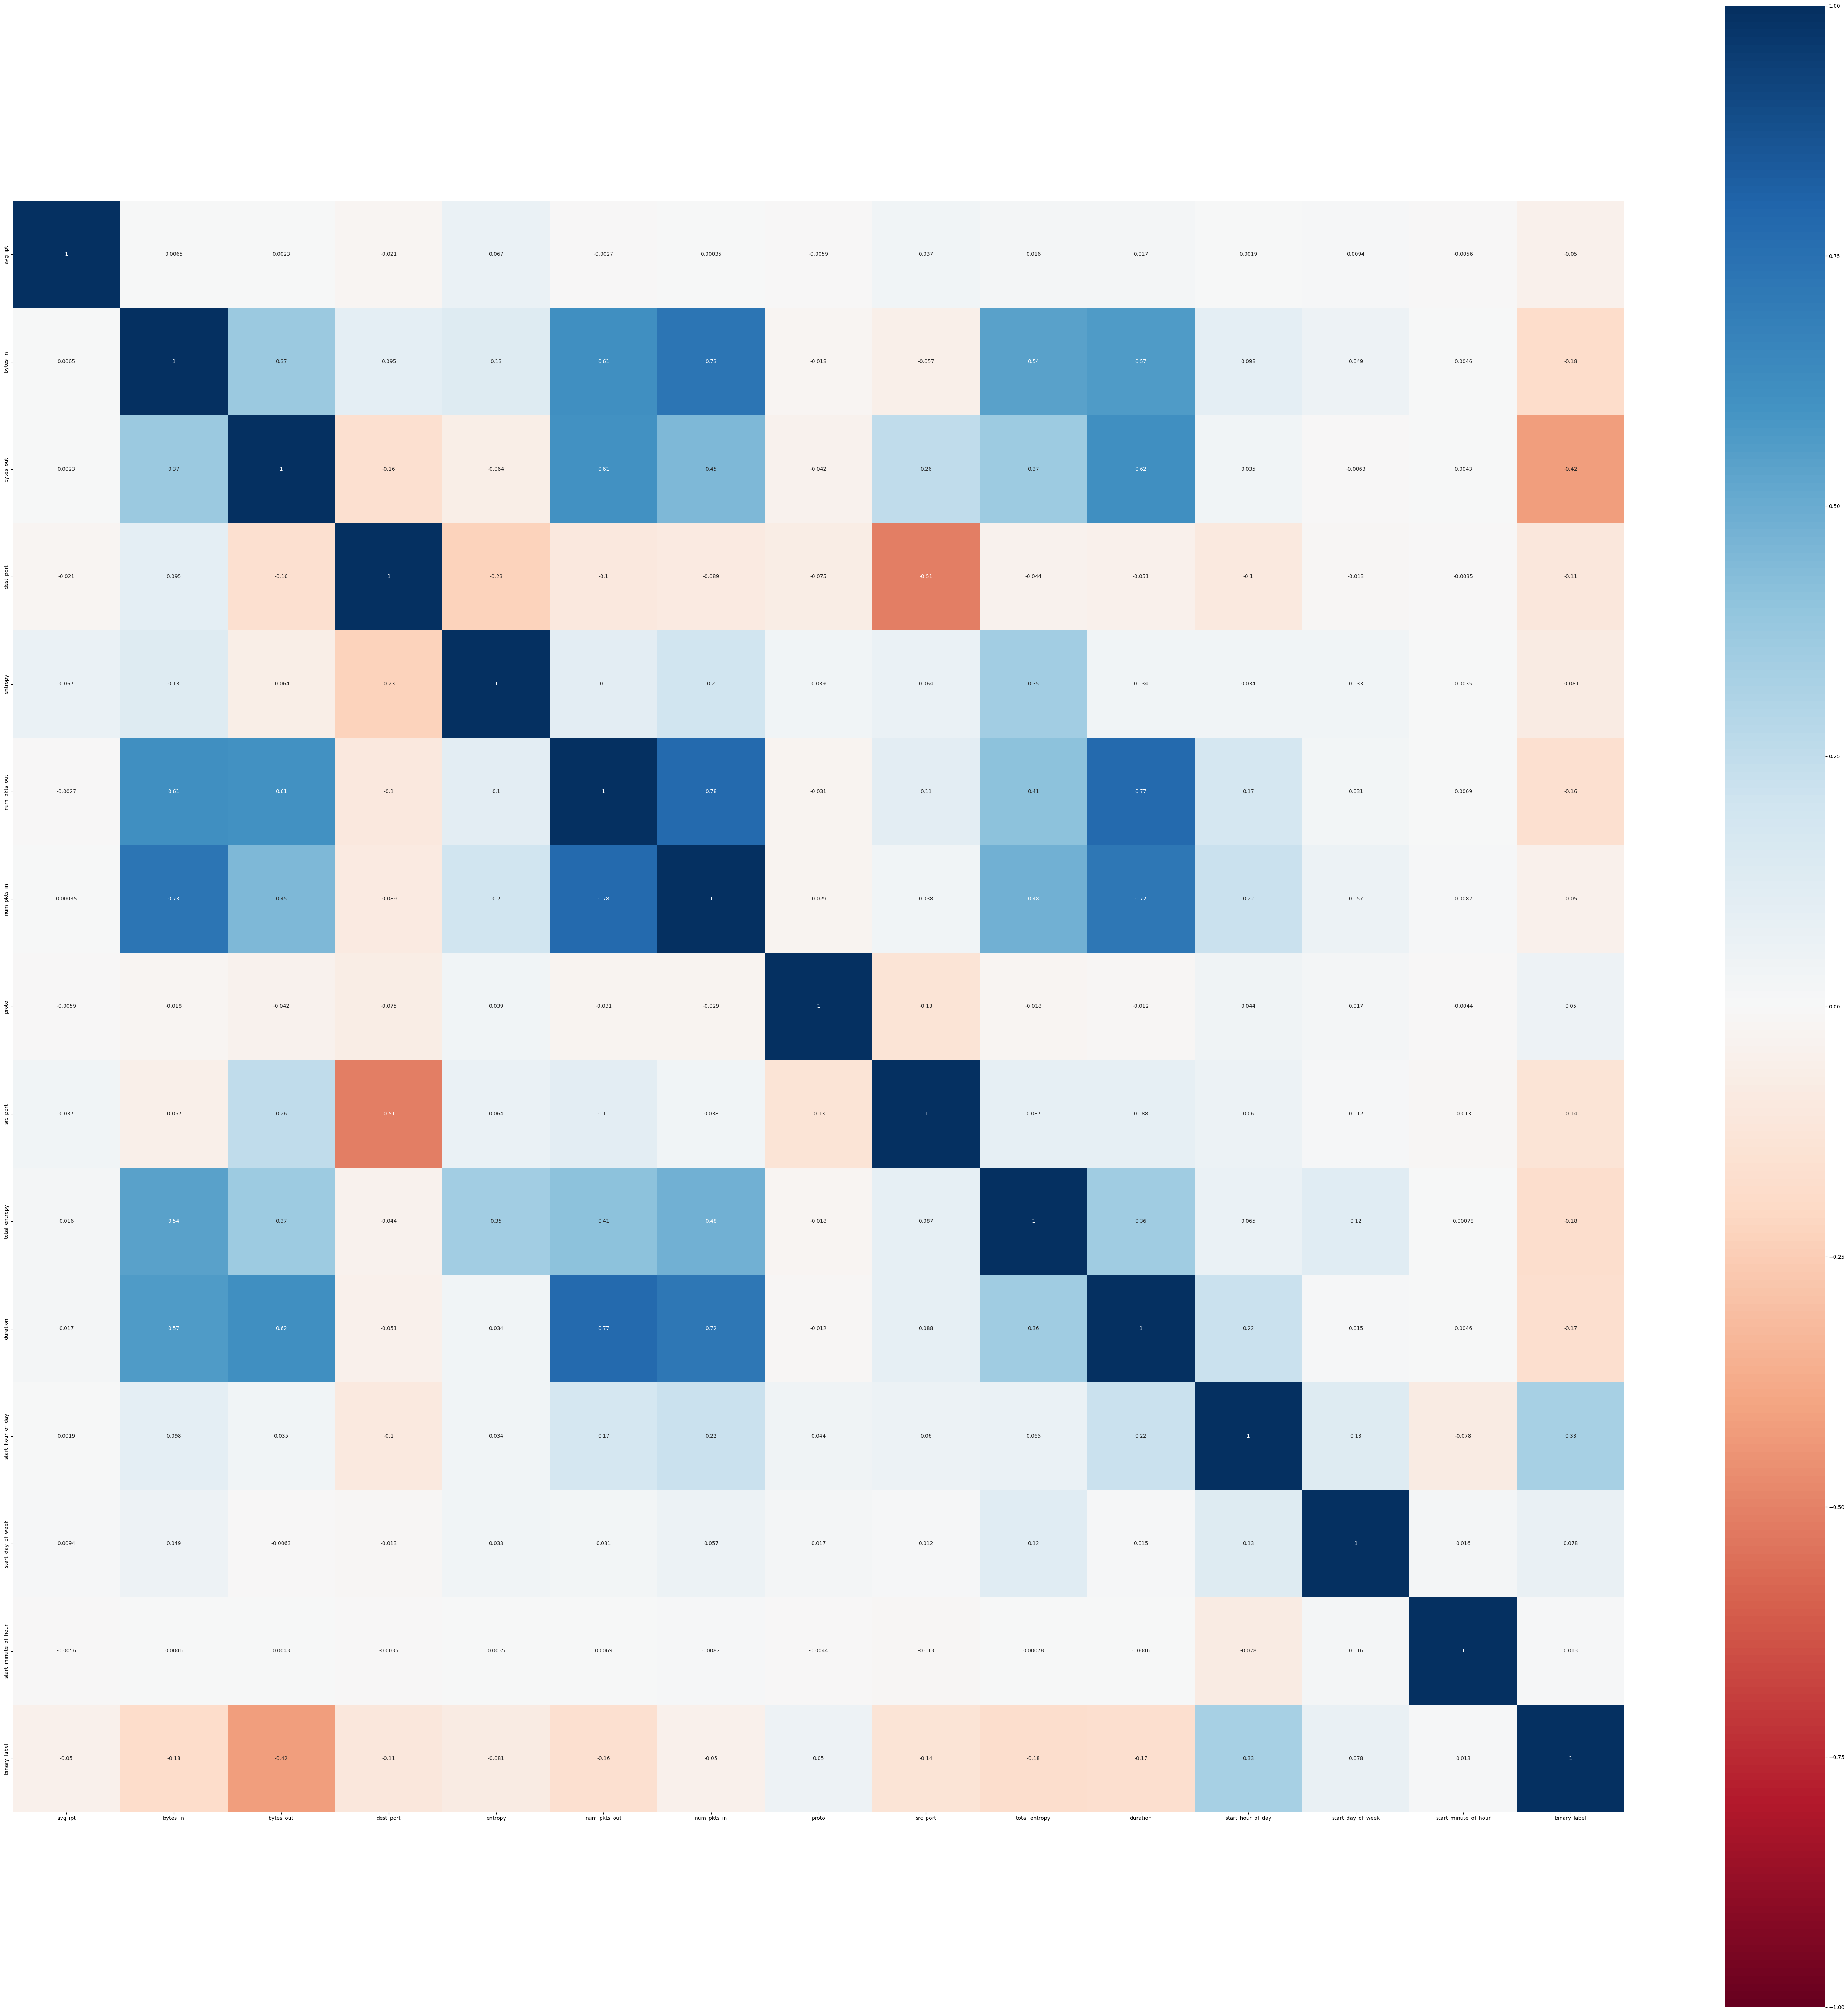

CPU times: user 2.38 s, sys: 165 ms, total: 2.54 s
Wall time: 2.56 s


In [19]:
%%time
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = df_balanced.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

In [20]:
%%time
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.90
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

set()
0
CPU times: user 2.28 ms, sys: 0 ns, total: 2.28 ms
Wall time: 2.25 ms


In [21]:
%%time
df_balanced.drop(correlated_col, axis=1, inplace=True)
print (df_balanced.shape)

(964168, 15)
CPU times: user 17.3 ms, sys: 20.4 ms, total: 37.6 ms
Wall time: 37.4 ms


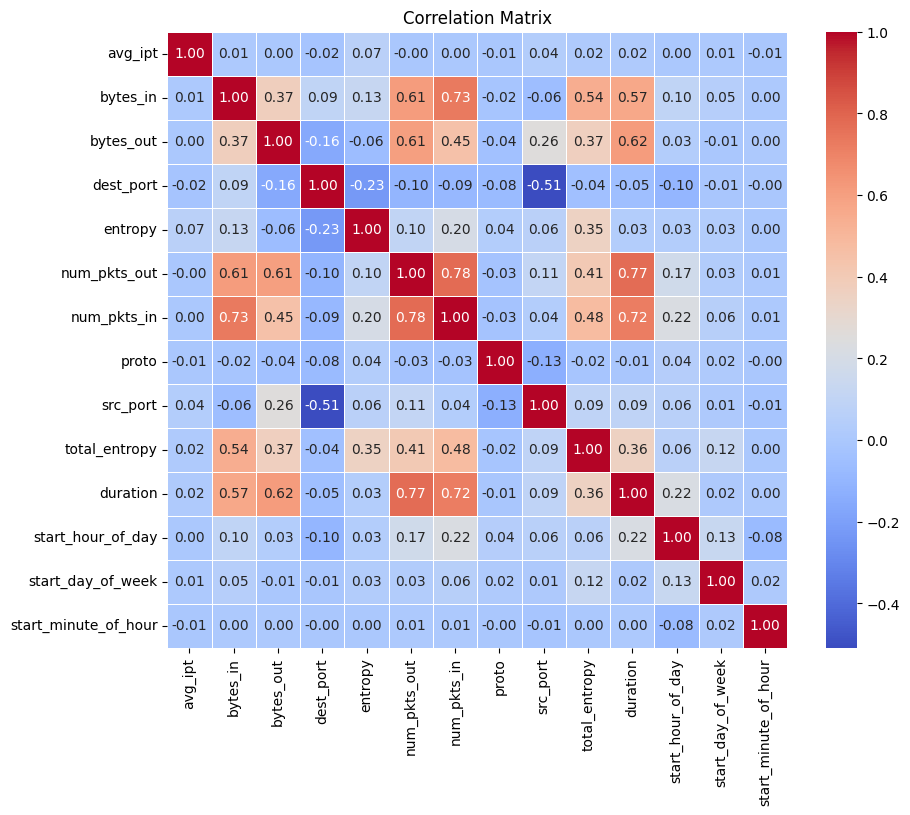

In [22]:
# Calculate correlation matrix
correlation_matrix = df_balanced.drop('binary_label', axis=1).corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

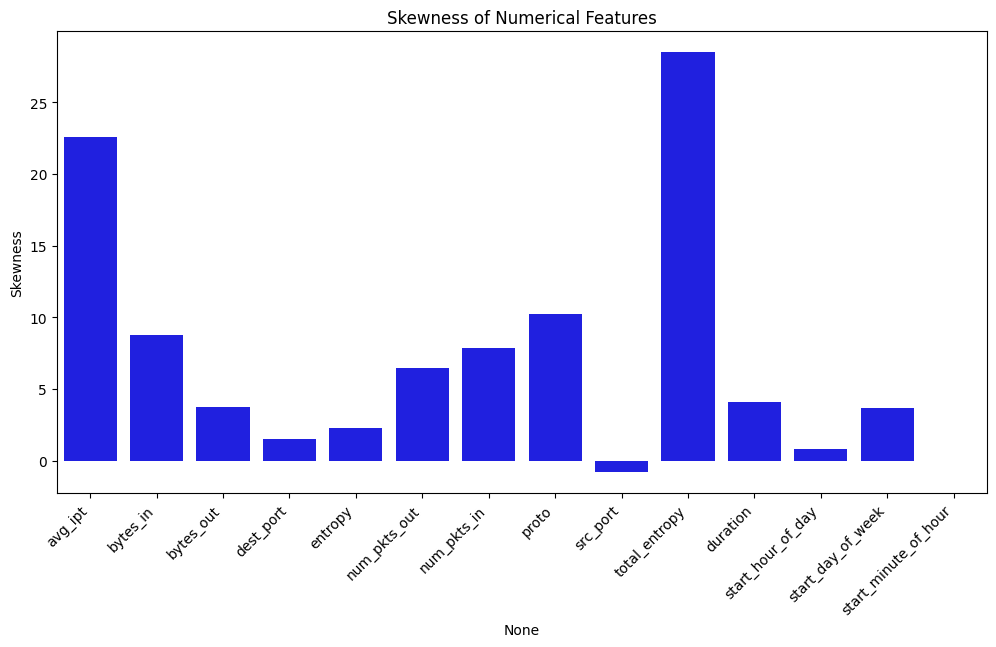

In [23]:
# Calculate skewness for each numerical column
skewness = df_balanced.drop('binary_label', axis=1).skew()

# Create a bar plot or a histogram of skewness values
plt.figure(figsize=(12, 6))
sns.barplot(x=skewness.index, y=skewness.values, color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Skewness of Numerical Features')
plt.ylabel('Skewness')
plt.show()

In [24]:
%%time
X=df_balanced.drop(["binary_label"], axis=1)
y=df_balanced["binary_label"]

CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 19.4 ms


In [25]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training set
X_scaled = scaler.fit_transform(X)

In [26]:
# Reshape data for LSTM
# LSTMs expect input in the format (samples, time steps, features)

# This is a critical step and depends on how you want to define your sequences.
# For example, you could group flows into sequences based on time windows, source IP,
# destination IP, or other criteria.
# For simplicity here, let's assume each row is a single time step in a sequence of length 1.
# This is not the typical use of LSTMs, but it demonstrates the reshaping.
# A more realistic approach would involve creating meaningful sequences of network events.

# Example: Reshaping for a single time step per sample
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data (using the reshaped data)
x_train, x_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, shuffle=True)

In [27]:
# --- Build the LSTM Model ---

# Define the model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])), # LSTM layer
    Dropout(0.3),
    LSTM(32), # Another LSTM layer, return_sequences=False for the last LSTM layer
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Compile the model
model_lstm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[tf.keras.metrics.AUC(name='auc')])

# Print model summary
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# --- Train the LSTM Model ---

# Calculate balance_weight if needed (similar to your MLP)
benign_count = y_train.value_counts()[0]
anomaly_count = y_train.value_counts()[1]
balance_weight = benign_count / anomaly_count if anomaly_count > 0 else 1.0
class_weights = {0: 1, 1: balance_weight}

print(f"Balance Weight: {balance_weight}")

Balance Weight: 1.1557143615727945


In [30]:
history_lstm = model_lstm.fit(x_train, y_train,
                              epochs=50, # Adjust epochs
                              batch_size=256, # Adjust batch size
                              validation_split=0.2,
                              class_weight=class_weights,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])


Epoch 1/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - auc: 0.9647 - loss: 0.2535 - val_auc: 0.9974 - val_loss: 0.0520
Epoch 2/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - auc: 0.9975 - loss: 0.0546 - val_auc: 0.9989 - val_loss: 0.0292
Epoch 3/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - auc: 0.9986 - loss: 0.0360 - val_auc: 0.9990 - val_loss: 0.0225
Epoch 4/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - auc: 0.9989 - loss: 0.0281 - val_auc: 0.9992 - val_loss: 0.0194
Epoch 5/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - auc: 0.9990 - loss: 0.0251 - val_auc: 0.9992 - val_loss: 0.0174
Epoch 6/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - auc: 0.9991 - loss: 0.0217 - val_auc: 0.9993 - val_loss: 0.0157
Epoch 7/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - auc: 0.9993 - loss: 0.0196 - val_auc: 0.9993 - val_loss: 0.0141
Epoch 8/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - auc: 0.9994 - loss: 0.0177 - val_auc: 0.9994 - val_loss: 0.0133
Epoch 9/50
2411/2411 ━━━━━━━━━━━

In [31]:
# --- Evaluate the LSTM Model ---

loss_lstm, auc_lstm = model_lstm.evaluate(x_test, y_test, verbose=0)
print(f"--- LSTM Classifier ---")
print(f"Test AUC: {auc_lstm:.4f}")

--- LSTM Classifier ---
Test AUC: 0.9998


In [32]:
# Get predictions and probabilities
y_pred_proba_lstm = model_lstm.predict(x_test).ravel()
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_lstm))

6027/6027 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    103684
           1       1.00      1.00      1.00     89150

    accuracy                           1.00    192834
   macro avg       1.00      1.00      1.00    192834
weighted avg       1.00      1.00      1.00    192834



In [33]:
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lstm))

ROC AUC Score:
0.9999610254467699


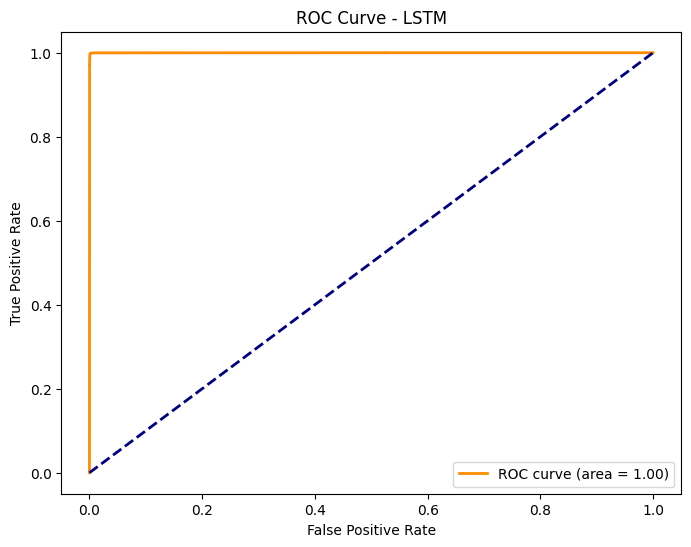

In [34]:
# Plot ROC curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_proba_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend(loc="lower right")
plt.show()

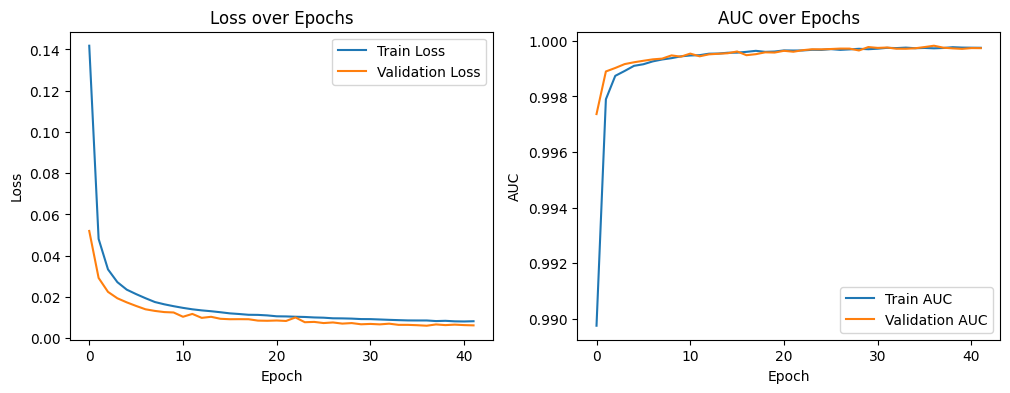

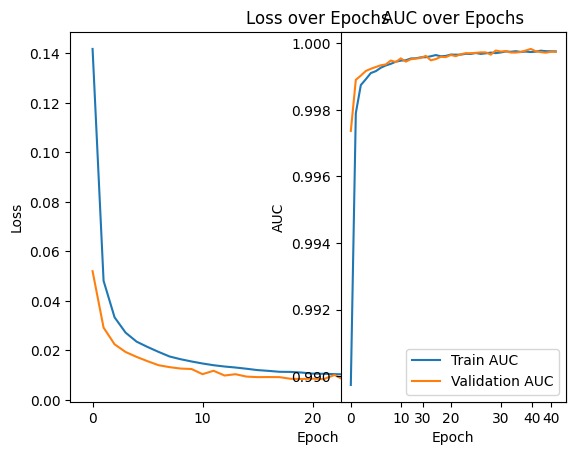

In [35]:
# Plot training history (optional)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['auc'], label='Train AUC')
plt.plot(history_lstm.history['val_auc'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['auc'], label='Train AUC')
plt.plot(history_lstm.history['val_auc'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [36]:
# Calculate the confusion matrix
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)

# Print the confusion matrix
print("Confusion Matrix for LSTM:")
print(conf_matrix_lstm)

Confusion Matrix for LSTM:
[[103555    129]
 [   179  88971]]


In [37]:
# Extract TN, FP, FN, TP from the confusion matrix
# The confusion matrix structure for binary classification in sklearn is:
# [[TN, FP],
#  [FN, TP]]
tn, fp, fn, tp = conf_matrix_lstm.ravel()

# Print the values
print("\nConfusion Matrix Components:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


Confusion Matrix Components:
True Negatives (TN): 103555
False Positives (FP): 129
False Negatives (FN): 179
True Positives (TP): 88971
